In [10]:
import librosa
from dotenv import load_dotenv
import assemblyai as aai
import os

# Load the .env file
load_dotenv()

aai.settings.api_key = os.getenv("ASSEMBLYAI_API_KEY")


REECORDS CONVERSATION, SAVES TO WAV

In [ ]:
import sounddevice as sd
from scipy.io.wavfile import write
import numpy as np
import speech_recognition as sr

fs = 44100  # Sample rate
channels = 1

print("Press ENTER to start recording...")
input()

print("Recording... Press ENTER again to stop.")
recorded_chunks = []

# Callback for non-blocking recording
def callback(indata, frames, time, status):
    recorded_chunks.append(indata.copy())

stream = sd.InputStream(samplerate=fs, channels=channels, callback=callback)
with stream:
    input()  # Wait until user presses Enter
    # Exiting the 'with' block stops the stream

# Combine all chunks
audio_np = np.concatenate(recorded_chunks, axis=0)
write("input_audio.wav", fs, audio_np)

print("Saved recording to input_audio.wav")


WAV TO TXT TRANSCRIPT, END AS SPEAKER A/B...

In [11]:
#path to audio file
audio_file = "input_audio.wav"

config = aai.TranscriptionConfig(
    speech_model=aai.SpeechModel.universal,
    speaker_labels=True 
)

transcript = aai.Transcriber(config=config).transcribe(audio_file)

if transcript.status == "error":
    raise RuntimeError(f"Transcription failed: {transcript.error}")

basename = os.path.splitext(os.path.basename(audio_file))[0]
out_path = f"REALTIME_transcript.txt"

with open(out_path, "w", encoding="utf-8") as f:
    for u in transcript.utterances:
        start = u.start / 1000
        end = u.end / 1000
        speaker = u.speaker
        text = u.text.replace("\n", " ")
        f.write(f"[ Start Time:{start} End Time:{end} ]\nSpeaker {speaker}: {text}\n")


print(f"Wrote transcript to {out_path}")


Wrote transcript to REALTIME_transcript.txt


ADD SPEAKER LABELS

In [ ]:
from Named_Transcript import rename_speakers_in_transcript

labeled_transcript_path= rename_speakers_in_transcript(out_path)


CONVERSATION JSON (FOR MINDMAP)


In [ ]:
from LLM_json_generator import generate_conversation_mindmap_json
import json

# CHANGE THIS TO LABELLED TRANSCRIPT FILE
transcript_path = labeled_transcript_path

with open(transcript_path, "r", encoding="utf-8") as f:
    transcript_text = f.read()

mindmap_data = generate_conversation_mindmap_json(transcript_text, source_file=transcript_path)

output_path = "mindmap.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(mindmap_data, f, indent=2)

print(f"✅ Mind map JSON generated and saved to {output_path}")

In [ ]:
import json
import networkx as nx
from pyvis.network import Network

# ------------------- Build Graph from Conversation JSON -------------------

def build_mindmap_graph(conversation_json):
    """
    Build a graph where:
    - Main topics are nodes
    - Subtopics are nodes
    - Edges represent introduction or discussion
    - Relationships are edges with types
    """
    G = nx.DiGraph()
    
    # Add main topics
    for topic in conversation_json.get("main_topics", []):
        topic_name = topic["topic"]
        G.add_node(topic_name, label=topic_name, type="topic", introduced_by=topic["introduced_by"], sentiment=topic["sentiment"])
        
        # Add subtopics
        for sub in topic.get("subtopics", []):
            sub_name = sub["subtopic"]
            G.add_node(sub_name, label=sub_name, type="subtopic", introduced_by=sub["introduced_by"], sentiment=sub["sentiment"])
            
            # Edge from main topic to subtopic
            G.add_edge(topic_name, sub_name, label=sub["stance"], introduced_by=sub["introduced_by"])
    
    # Add explicit relationships
    for rel in conversation_json.get("relationships", []):
        G.add_edge(rel["from"], rel["to"], label=rel["type"], introduced_by=rel["initiated_by"])
    
    return G

# ------------------- Visualize Graph with PyVis -------------------

def visualize_graph(G, output_html="mindmap.html"):
    """
    Create an interactive visualization of the graph using PyVis
    """
    net = Network(height="750px", width="100%", directed=True, notebook=False)
    
    # Add nodes
    for node, data in G.nodes(data=True):
        color_map = {"topic": "#97C2FC", "subtopic": "#FFD700"}  # Blue for main topic, yellow for subtopics
        sentiment_color = {"positive": "#8BC34A", "neutral": "#FFC107", "negative": "#F44336"}
        color = color_map.get(data.get("type"), "#D3D3D3")
        color = sentiment_color.get(data.get("sentiment"), color)
        
        title = f"{data.get('label')}<br>Introduced by: {data.get('introduced_by')}<br>Sentiment: {data.get('sentiment')}"
        net.add_node(node, label=data.get("label"), title=title, color=color)
    
    # Add edges
    for u, v, data in G.edges(data=True):
        label = data.get("label", "")
        net.add_edge(u, v, label=label, title=f"{label} (by {data.get('introduced_by', 'unknown')})")
    
    # Generate interactive HTML
    #net.show(output_html)
    net.write_html(output_html)
    print(f"✅ Mindmap saved to {output_html}")

# ------------------- Example Usage -------------------

if __name__ == "__main__":
    # Load your JSON
    with open("mindmap.json", "r", encoding="utf-8") as f:
        conversation_json = json.load(f)
    
    # Build graph
    G = build_mindmap_graph(conversation_json)
    
    # Visualize and save HTML
    visualize_graph(G, "digital_transformation_mindmap.html")


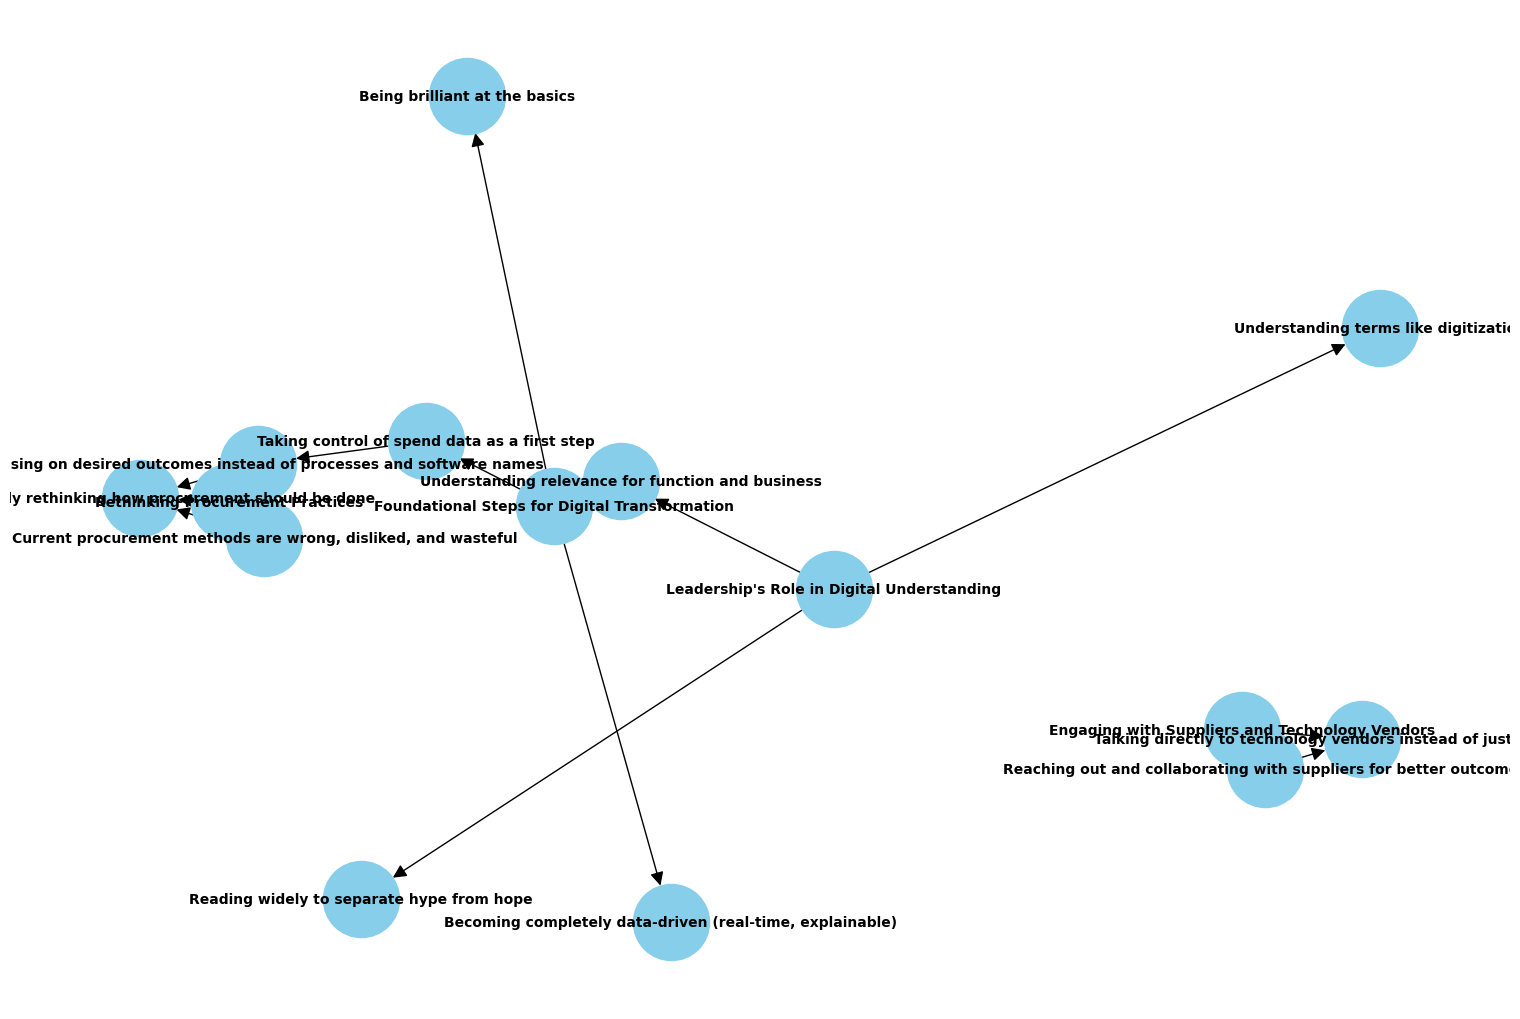

In [ ]:
from matplotlib import pyplot as plt

def visualize_graph_matplotlib(G):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(15,10))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=20)
    edge_labels = nx.get_edge_attributes(G,'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

visualize_graph_matplotlib(G)

In [ ]:
!pip install pyvis

  Using cached pyvis-0.3.2-py3-none-any.whl.metadata (1.7 kB)
Using cached pyvis-0.3.2-py3-none-any.whl (756 kB)


FOR SPEAKER IDENTIFICATION AND CONTEXTUAL INFORMATION

In [ ]:
from speaker_identify import extract_raw_headers, normalize_header_to_name, unique_preserve_order
import os
import re
import json
import time
from pathlib import Path
from dotenv import load_dotenv
from google_search import google_search_person

load_dotenv()

API_KEY = os.getenv("CUSTOM_SEARCH_API_KEY", "").strip()
CX = os.getenv("CUSTOM_SEARCH_ENGINE_ID", "").strip()

### REPLACE WITH LABELLED TRANSCRIPT FILE
input_path = "REALTIME_transcript.txt"  # transcript file
out_dir = "out_speakers"  # where to save outputs
pages = 1  # Google pages per speaker (10 results/page)
pause = 1.5  # seconds between API calls
query_template = '"{name}"'  # search pattern
dry_run = False  # True = skip Google API calls (for testing)

text = Path(input_path).read_text(encoding="utf-8", errors="ignore")

raw_headers = extract_raw_headers(text)
names = [normalize_header_to_name(h) for h in raw_headers if h.strip()]
speakers = unique_preserve_order(names)

out_dir = Path(out_dir)
(out_dir / "profiles").mkdir(parents=True, exist_ok=True)

print(f"✅ Found {len(speakers)} unique speakers:\n")
for i, s in enumerate(speakers, 1):
    print(f"{i:>2}. {s}")

summary = {
    "input": input_path,
    "total_unique_speakers": len(speakers),
    "query_template": query_template,
    "pages": pages,
    "pause": pause,
    "speakers": [],
    "generated_at": time.time(),
}

if dry_run:
    Path(out_dir / "speakers_summary.json").write_text(
        json.dumps(summary, ensure_ascii=False, indent=2), encoding="utf-8"
    )
    print(f"\n--dry-run=True: wrote only {out_dir/'speakers_summary.json'}")
else:
    if not API_KEY or not CX:
        raise SystemExit("❌ Missing CUSTOM_SEARCH_API_KEY or CUSTOM_SEARCH_ENGINE_ID (.env)")

    for name in speakers:
        print(f"\n[+] Fetching: {name}")
        try:
            info = google_search_person(
                person_name=name,
                api_key=API_KEY,
                cx=CX,
                num_pages=pages,
                pause=pause,
                query_template=query_template,
            )
        except Exception as e:
            print(f"   ✗ Error for {name}: {e}")
            info = {
                "query": name,
                "rendered_query": query_template.format(name=name),
                "total_results": 0,
                "texts": [],
                "links": [],
                "error": str(e),
            }

        slug = re.sub(r"[^0-9A-Za-z\-_]+", "_", name).strip("_")
        out_file = out_dir / "profiles" / f"{slug}_info.json"
        out_file.write_text(json.dumps(info, ensure_ascii=False, indent=2), encoding="utf-8")

        summary["speakers"].append({
            "name": name,
            "file": str(out_file),
            "total_results": info.get("total_results", 0),
        })

    Path(out_dir / "speakers_summary.json").write_text(
        json.dumps(summary, ensure_ascii=False, indent=2), encoding="utf-8"
    )

    print(f"\n✅ Done.\nProfiles saved under: {out_dir/'profiles'}\nSummary: {out_dir/'speakers_summary.json'}")


SEND TO FAISS

In [ ]:
from RAG_FRAMEWORK import (
    PersonDatabase,
    prepare_mindmap_chunks,
    build_mindmap_index,
    query_both_indexes,
    make_rag_make_sense,
)
# Load person JSON from scraper
person_db = PersonDatabase()
json_folder= "out_speakers/profiles"


# Iterate over all JSON files in the folder
for filename in os.listdir(json_folder):
    if filename.endswith(".json"):
        json_path = os.path.join(json_folder, filename)
        print(f"Processing {json_path}...")
        with open(json_path, "r") as f:
            scraper_json = json.load(f)
        person_db.load_from_scraper_json(scraper_json)


# Build FAISS
person_db.build_person_chunks()
person_db.create_faiss_index()

# Load mindmap
with open("mindmap.json", "r") as f:
    mindmap_json = json.load(f)
mindmap_chunks = prepare_mindmap_chunks(mindmap_json, person_db)
mindmap_index = build_mindmap_index(mindmap_chunks)

print("\nEnter your questions about the conversation (type 'exit' to quit):")
history={}

while True:
    
    query = input("\nYour query: ").strip()
    if query.lower() in ["exit", "quit"]:
        print("Exiting interactive session.")
        break
    
    results = query_both_indexes(mindmap_index, mindmap_chunks, person_db, query)
    for r in results:
        print(f"{r['source']} | {r.get('person_id')} | {r['text'][:100]}...")

    # RAG answer
    answer = make_rag_make_sense(query, results, history)
    print("\n💡 Answer:\n", answer)

    history[query] = answer
    
    print("\n✅ Chat History:")
    print("="*20)
    for q, a in history.items():
        print(f"Q: {q}\nA: {a}\n")
    print("="*20)


